# Chest Xray Pneumonia Classification

<img src="images/chest_xray.jpeg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary


## Business Understanding

## Data Understanding

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers

In [2]:
train_folder = 'chest_xray/train/'
test_folder = 'chest_xray/test/'
val_folder = 'chest_xray/val/'

In [3]:
# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, batch_size=624) 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, batch_size=16)

# get all the data in the directory split/train (542 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [4]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [5]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


## Data Preparation

In [6]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [7]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

## Baseline Model

In [99]:
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(5, activation='relu', input_shape=(196608,))) # 1 hidden layer
baseline_model.add(layers.Dense(2, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [100]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [101]:
history = baseline_model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
118/118 [==============================] - 3s 24ms/step - loss: 0.6676 - accuracy: 0.7283 - val_loss: 0.6446 - val_accuracy: 0.7353
Epoch 2/50
118/118 [==============================] - 2s 21ms/step - loss: 0.6313 - accuracy: 0.7310 - val_loss: 0.6173 - val_accuracy: 0.7353
Epoch 3/50
118/118 [==============================] - 2s 19ms/step - loss: 0.6109 - accuracy: 0.7310 - val_loss: 0.6012 - val_accuracy: 0.7353
Epoch 4/50
118/118 [==============================] - 2s 19ms/step - loss: 0.5991 - accuracy: 0.7310 - val_loss: 0.5923 - val_accuracy: 0.7353
Epoch 5/50
118/118 [==============================] - 2s 20ms/step - loss: 0.5924 - accuracy: 0.7310 - val_loss: 0.5869 - val_accuracy: 0.7353
Epoch 6/50
118/118 [==============================] - 2s 17ms/step - loss: 0.5884 - accuracy: 0.7310 - val_loss: 0.5834 - val_accuracy: 0.7353
Epoch 7/50
118/118 [==============================] - 2s 18ms/step - loss: 0.5859 - accuracy: 0.7310 - val_loss: 0.5815 - val_accuracy: 0.7353

In [102]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = history.history
# Print the keys
baseline_model_val_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

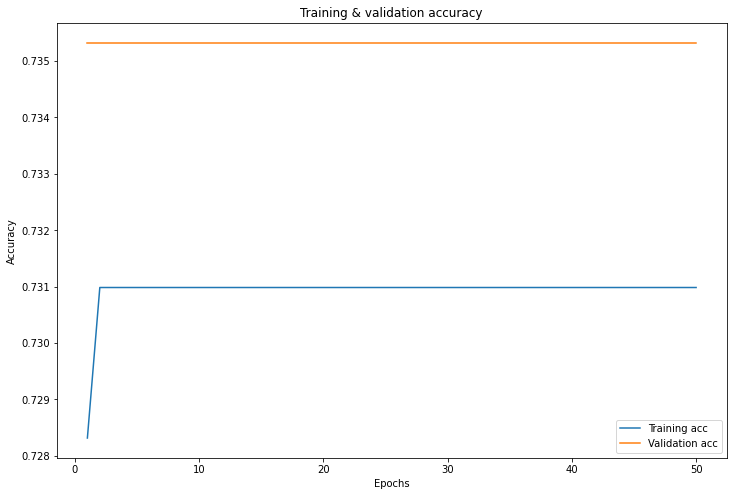

In [103]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['accuracy'] 
val_acc_values = baseline_model_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

In [104]:
results_train = baseline_model.evaluate(X_train, y_train)

118/118 [==============================] - 1s 9ms/step - loss: 0.5823 - accuracy: 0.7310


In [106]:
results_val = baseline_model.evaluate(X_val, y_val)

30/30 [==============================] - 0s 8ms/step - loss: 0.5779 - accuracy: 0.7353


In [107]:
baseline_model.evaluate(X_test, y_test)

37/37 [==============================] - 0s 12ms/step - loss: 0.5923 - accuracy: 0.7210


[0.5922738313674927, 0.7209897637367249]

## 2nd Model

In [135]:
model_2 = models.Sequential()
model_2.add(layers.Dense(75, activation='relu', input_shape=(196608,))) # 4 hidden layer
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [136]:
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [137]:
history_2 = model_2.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/100
118/118 [==============================] - 6s 54ms/step - loss: 0.7881 - accuracy: 0.7171 - val_loss: 0.8978 - val_accuracy: 0.7353
Epoch 2/100
118/118 [==============================] - 6s 52ms/step - loss: 0.4437 - accuracy: 0.7641 - val_loss: 0.6343 - val_accuracy: 0.7556
Epoch 3/100
118/118 [==============================] - 6s 55ms/step - loss: 0.3609 - accuracy: 0.8599 - val_loss: 0.6608 - val_accuracy: 0.4205
Epoch 4/100
118/118 [==============================] - 6s 54ms/step - loss: 0.3386 - accuracy: 0.8764 - val_loss: 0.3899 - val_accuracy: 0.8442
Epoch 5/100
118/118 [==============================] - 6s 52ms/step - loss: 0.3308 - accuracy: 0.8746 - val_loss: 0.2999 - val_accuracy: 0.8858
Epoch 6/100
118/118 [==============================] - 6s 51ms/step - loss: 0.2999 - accuracy: 0.8973 - val_loss: 0.6106 - val_accuracy: 0.5507
Epoch 7/100
118/118 [==============================] - 6s 54ms/step - loss: 0.2942 - accuracy: 0.8970 - val_loss: 0.8310 - val_accuracy:

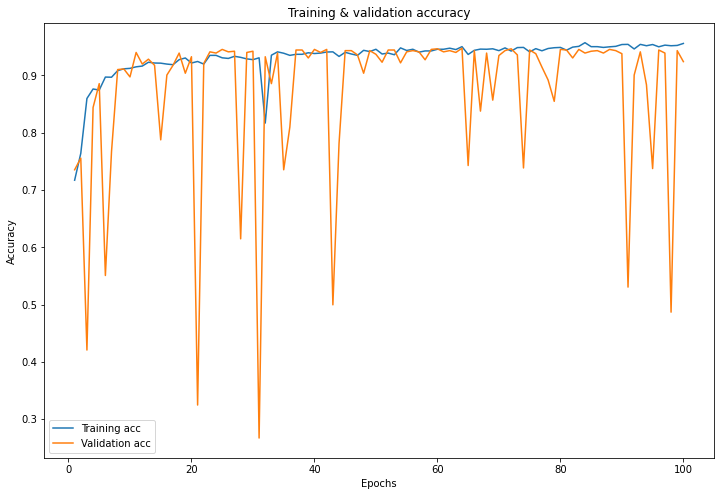

In [138]:
# Access the history attribute and store the dictionary
model_2_val_dict = history_2.history
# Print the keys
model_2_val_dict.keys()

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_2_val_dict['accuracy'] 
val_acc_values = model_2_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

In [139]:
model_2.evaluate(X_train, y_train)

118/118 [==============================] - 2s 17ms/step - loss: 0.1381 - accuracy: 0.9474


[0.13805033266544342, 0.947424590587616]

In [140]:
model_2.evaluate(X_val, y_val)

30/30 [==============================] - 0s 15ms/step - loss: 0.1829 - accuracy: 0.9242


[0.1829124093055725, 0.9242262244224548]

In [141]:
model_2.evaluate(X_test, y_test)

37/37 [==============================] - 1s 16ms/step - loss: 0.1885 - accuracy: 0.9283


[0.18849815428256989, 0.9283276200294495]

## Model 2.1

In [155]:
model_2_1 = models.Sequential()
model_2_1.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # 4 hidden layer
model_2_1.add(layers.Dense(10, activation='relu'))
model_2_1.add(layers.Dense(1, activation='sigmoid'))

In [156]:
model_2_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [157]:
history_2_1 = model_2_1.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=96,
                    validation_data=(X_val, y_val))

Epoch 1/50
40/40 [==============================] - 2s 60ms/step - loss: 0.9143 - accuracy: 0.7011 - val_loss: 0.5298 - val_accuracy: 0.7353
Epoch 2/50
40/40 [==============================] - 2s 50ms/step - loss: 0.4737 - accuracy: 0.7707 - val_loss: 0.4279 - val_accuracy: 0.7492
Epoch 3/50
40/40 [==============================] - 2s 49ms/step - loss: 0.4388 - accuracy: 0.7980 - val_loss: 0.3444 - val_accuracy: 0.8645
Epoch 4/50
40/40 [==============================] - 2s 50ms/step - loss: 0.4021 - accuracy: 0.8321 - val_loss: 0.3392 - val_accuracy: 0.8356
Epoch 5/50
40/40 [==============================] - 2s 50ms/step - loss: 0.3696 - accuracy: 0.8546 - val_loss: 0.4360 - val_accuracy: 0.7962
Epoch 6/50
40/40 [==============================] - 2s 50ms/step - loss: 0.3629 - accuracy: 0.8588 - val_loss: 0.5937 - val_accuracy: 0.7663
Epoch 7/50
40/40 [==============================] - 2s 50ms/step - loss: 0.3585 - accuracy: 0.8626 - val_loss: 0.3627 - val_accuracy: 0.8218
Epoch 8/50
40

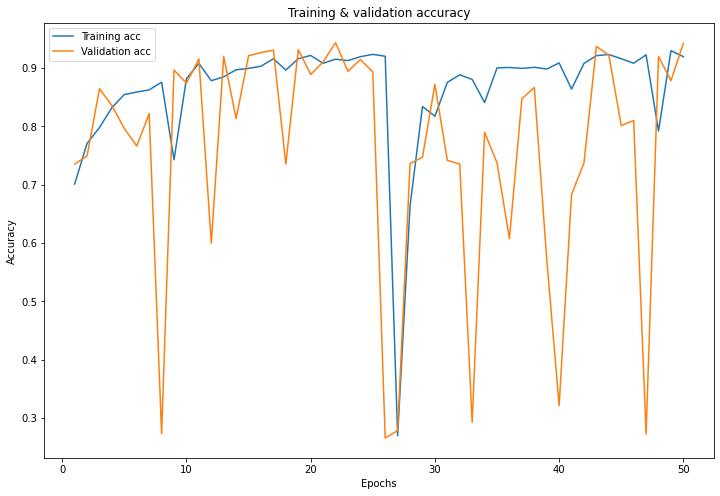

In [158]:
# Access the history attribute and store the dictionary
model_21_val_dict = history_2_1.history
# Print the keys
model_21_val_dict.keys()

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_21_val_dict['accuracy'] 
val_acc_values = model_21_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

In [160]:
model_2_2 = models.Sequential()
model_2_2.add(layers.Dense(8, activation='relu', input_shape=(196608,))) # 4 hidden layer
model_2_2.add(layers.Dense(4, activation='relu'))
model_2_2.add(layers.Dense(1, activation='sigmoid'))

model_2_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_2_2 = model_2_2.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=96,
                    validation_data=(X_val, y_val))

Epoch 1/50
40/40 [==============================] - 2s 57ms/step - loss: 0.5811 - accuracy: 0.7305 - val_loss: 0.6892 - val_accuracy: 0.7353
Epoch 2/50
40/40 [==============================] - 2s 50ms/step - loss: 0.5034 - accuracy: 0.7331 - val_loss: 0.6186 - val_accuracy: 0.7353
Epoch 3/50
40/40 [==============================] - 2s 52ms/step - loss: 0.4612 - accuracy: 0.8004 - val_loss: 0.6157 - val_accuracy: 0.6265
Epoch 4/50
40/40 [==============================] - 2s 49ms/step - loss: 0.4063 - accuracy: 0.8369 - val_loss: 0.3774 - val_accuracy: 0.8047
Epoch 5/50
40/40 [==============================] - 2s 49ms/step - loss: 0.3925 - accuracy: 0.8417 - val_loss: 0.4469 - val_accuracy: 0.7844
Epoch 6/50
40/40 [==============================] - 2s 48ms/step - loss: 0.3656 - accuracy: 0.8578 - val_loss: 0.3198 - val_accuracy: 0.8655
Epoch 7/50
40/40 [==============================] - 2s 46ms/step - loss: 0.3293 - accuracy: 0.8842 - val_loss: 0.5562 - val_accuracy: 0.6361
Epoch 8/50
40

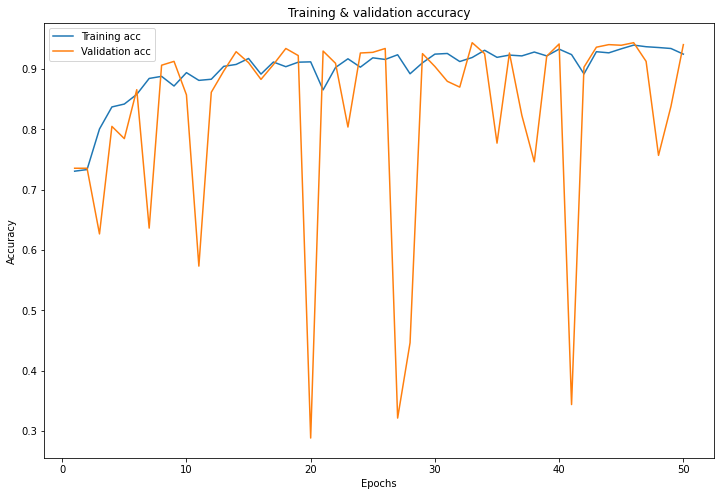

In [161]:
# Access the history attribute and store the dictionary
model_22_val_dict = history_2_2.history
# Print the keys
model_22_val_dict.keys()

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_22_val_dict['accuracy'] 
val_acc_values = model_22_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

## Third Model: Dropout

In [121]:
model_3 = models.Sequential()

model_3.add(layers.Dense(75, activation='relu', input_shape=(196608,))) 
model_3.add(layers.Dropout(0.3))

model_3.add(layers.Dense(32, activation='relu')) 
model_3.add(layers.Dropout(0.3))

# Add the output layer
model_3.add(layers.Dense(1, activation='sigmoid'))

In [122]:
model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [123]:
history_3 = model_3.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
118/118 [==============================] - 7s 63ms/step - loss: 0.9049 - accuracy: 0.7043 - val_loss: 0.4773 - val_accuracy: 0.7353
Epoch 2/50
118/118 [==============================] - 6s 54ms/step - loss: 0.5313 - accuracy: 0.7280 - val_loss: 0.5543 - val_accuracy: 0.8826
Epoch 3/50
118/118 [==============================] - 6s 53ms/step - loss: 0.5341 - accuracy: 0.7515 - val_loss: 0.3927 - val_accuracy: 0.7812
Epoch 4/50
118/118 [==============================] - 6s 52ms/step - loss: 0.4795 - accuracy: 0.7748 - val_loss: 0.4045 - val_accuracy: 0.7364
Epoch 5/50
118/118 [==============================] - 6s 52ms/step - loss: 0.4212 - accuracy: 0.7972 - val_loss: 2.2661 - val_accuracy: 0.2679
Epoch 6/50
118/118 [==============================] - 6s 52ms/step - loss: 0.5111 - accuracy: 0.7275 - val_loss: 0.3647 - val_accuracy: 0.7353
Epoch 7/50
118/118 [==============================] - 6s 52ms/step - loss: 0.4746 - accuracy: 0.7310 - val_loss: 0.3408 - val_accuracy: 0.7353

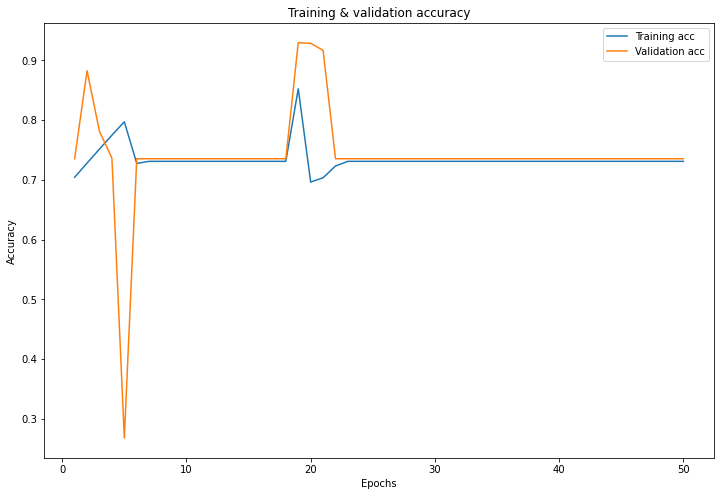

In [124]:
# Access the history attribute and store the dictionary
model_3_val_dict = history_3.history
# Print the keys
model_3_val_dict.keys()

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_3_val_dict['accuracy'] 
val_acc_values = model_3_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

In [125]:
model_3.evaluate(X_train, y_train)

118/118 [==============================] - 2s 17ms/step - loss: 0.5861 - accuracy: 0.7310


[0.5860926508903503, 0.7309848070144653]

In [126]:
model_3.evaluate(X_val, y_val)

30/30 [==============================] - 0s 15ms/step - loss: 0.5824 - accuracy: 0.7353


[0.5823835134506226, 0.7353255152702332]

## Fourth Model: L2 Regularization

In [ ]:
model_4 = models.Sequential()

# Add the input and first hidden layer
model_4.add(layers.Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(196608,)))

# Add another hidden layer
model_4.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
model_4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_4 = model_4.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

In [ ]:
model_4.evaluate(X_train, y_train)

In [ ]:
model_4.evaluate(X_val, y_val)

## Fifth Model: CNN

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_y, test_size=0.5)

In [9]:
X_train.shape

(2608, 256, 256, 3)

In [10]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model_5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
history_5 = model_5.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/30
41/41 [==============================] - 92s 2s/step - loss: 0.5495 - accuracy: 0.7531 - val_loss: 0.9141 - val_accuracy: 0.5000
Epoch 2/30
41/41 [==============================] - 89s 2s/step - loss: 0.4998 - accuracy: 0.7673 - val_loss: 0.9225 - val_accuracy: 0.5000
Epoch 3/30
41/41 [==============================] - 88s 2s/step - loss: 0.4584 - accuracy: 0.7795 - val_loss: 0.7808 - val_accuracy: 0.6250
Epoch 4/30
41/41 [==============================] - 89s 2s/step - loss: 0.4046 - accuracy: 0.8355 - val_loss: 0.8919 - val_accuracy: 0.6250
Epoch 5/30
41/41 [==============================] - 88s 2s/step - loss: 0.3545 - accuracy: 0.8478 - val_loss: 0.6348 - val_accuracy: 0.7500
Epoch 6/30
41/41 [==============================] - 87s 2s/step - loss: 0.2678 - accuracy: 0.8957 - val_loss: 0.6561 - val_accuracy: 0.7500
Epoch 7/30
41/41 [==============================] - 88s 2s/step - loss: 0.2592 - accuracy: 0.8992 - val_loss: 0.5467 - val_accuracy: 0.8125
Epoch 8/30
41/41 [==

In [13]:
model_5.evaluate(X_train, y_train)

82/82 [==============================] - 15s 184ms/step - loss: 0.0868 - accuracy: 0.9655


[0.08676890283823013, 0.9654908180236816]

In [14]:
model_5.evaluate(val_images, val_y)

1/1 [==============================] - 0s 997us/step - loss: 0.6269 - accuracy: 0.6875


[0.62685626745224, 0.6875]

## Final Model Evaluation

## Conclusion

## Next Steps